# Tutorial 4: Complete Workflow and Real-World Case Study

**Duration:** ~45-60 minutes

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Execute a complete spectral matching workflow** from start to finish
2. **Preprocess earthquake data** appropriately
3. **Choose between methods** based on project requirements
4. **Assess match quality** comprehensively
5. **Make informed decisions** for real engineering applications
6. **Generate publication-quality outputs** and reports

---

## Prerequisites

- Complete Tutorials 1-3
- Understand both FFT and GWM methods
- Familiar with intensity metrics

---

## Case Study: Designing a Hospital in California

### The Scenario

You're a structural engineer tasked with designing a **7-story reinforced concrete hospital** in Southern California. 

**Building characteristics:**
- Height: ~25 meters
- Estimated fundamental period: T ≈ 0.7 seconds
- Importance factor: 1.5 (essential facility)
- Must remain operational after design-level earthquake

**Seismic requirements:**
- Site-specific Uniform Hazard Spectrum (UHS) for 2500-year return period
- Target period range: 0.2 - 1.5 seconds (fundamental mode + higher modes)
- Need 7 matched ground motions for nonlinear time-history analysis
- Building code requires >90% spectral match in target band

**Task:** Take the 1940 El Centro earthquake record and match it to the target UHS.

---

## Setup and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import sys
import os

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

# Add the spectral_matching package
sys.path.insert(0, os.path.abspath('../src'))

from spectral_matching import (
    load_acceleration_record,
    load_target_spectrum,
    save_acceleration_record,
    response_spectrum,
    baseline_correction,
    scale_to_target_band,
    iterative_fft_match,
    greedy_wavelet_match,
    arias_intensity,
    cumulative_absolute_velocity,
    cumulative_metric,
    plot_spectra,
    plot_time_history
)

print("✓ All libraries and functions loaded successfully!")
print(f"✓ Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries and functions loaded successfully!
✓ Analysis started at: 2026-02-14 10:40:28


---

## Step 1: Load and Inspect Data

### 1.1 Load Earthquake Record

In [3]:
# Load the 1940 El Centro earthquake (North-South component)
time, acceleration, dt = load_acceleration_record("../src/data/elcentro_NS.dat.txt")

print("📁 EARTHQUAKE RECORD LOADED")
print("="*60)
print(f"Record: 1940 El Centro Earthquake (Imperial Valley)")
print(f"Component: North-South")
print(f"Magnitude: 6.9")
print(f"\nDigital characteristics:")
print(f"  Duration: {time[-1]:.2f} seconds")
print(f"  Time step (dt): {dt:.4f} seconds ({1/dt:.1f} Hz sampling)")
print(f"  Number of points: {len(acceleration)}")
print(f"  Peak Ground Acceleration (PGA): {np.max(np.abs(acceleration)):.3f} m/s²")
print(f"  Mean: {np.mean(acceleration):.6f} m/s² (should be near zero)")
print(f"  Std dev: {np.std(acceleration):.3f} m/s²")

📁 EARTHQUAKE RECORD LOADED
Record: 1940 El Centro Earthquake (Imperial Valley)
Component: North-South
Magnitude: 6.9

Digital characteristics:
  Duration: 53.74 seconds
  Time step (dt): 0.0200 seconds (50.0 Hz sampling)
  Number of points: 2688
  Peak Ground Acceleration (PGA): 3.420 m/s²
  Mean: 0.000481 m/s² (should be near zero)
  Std dev: 0.460 m/s²


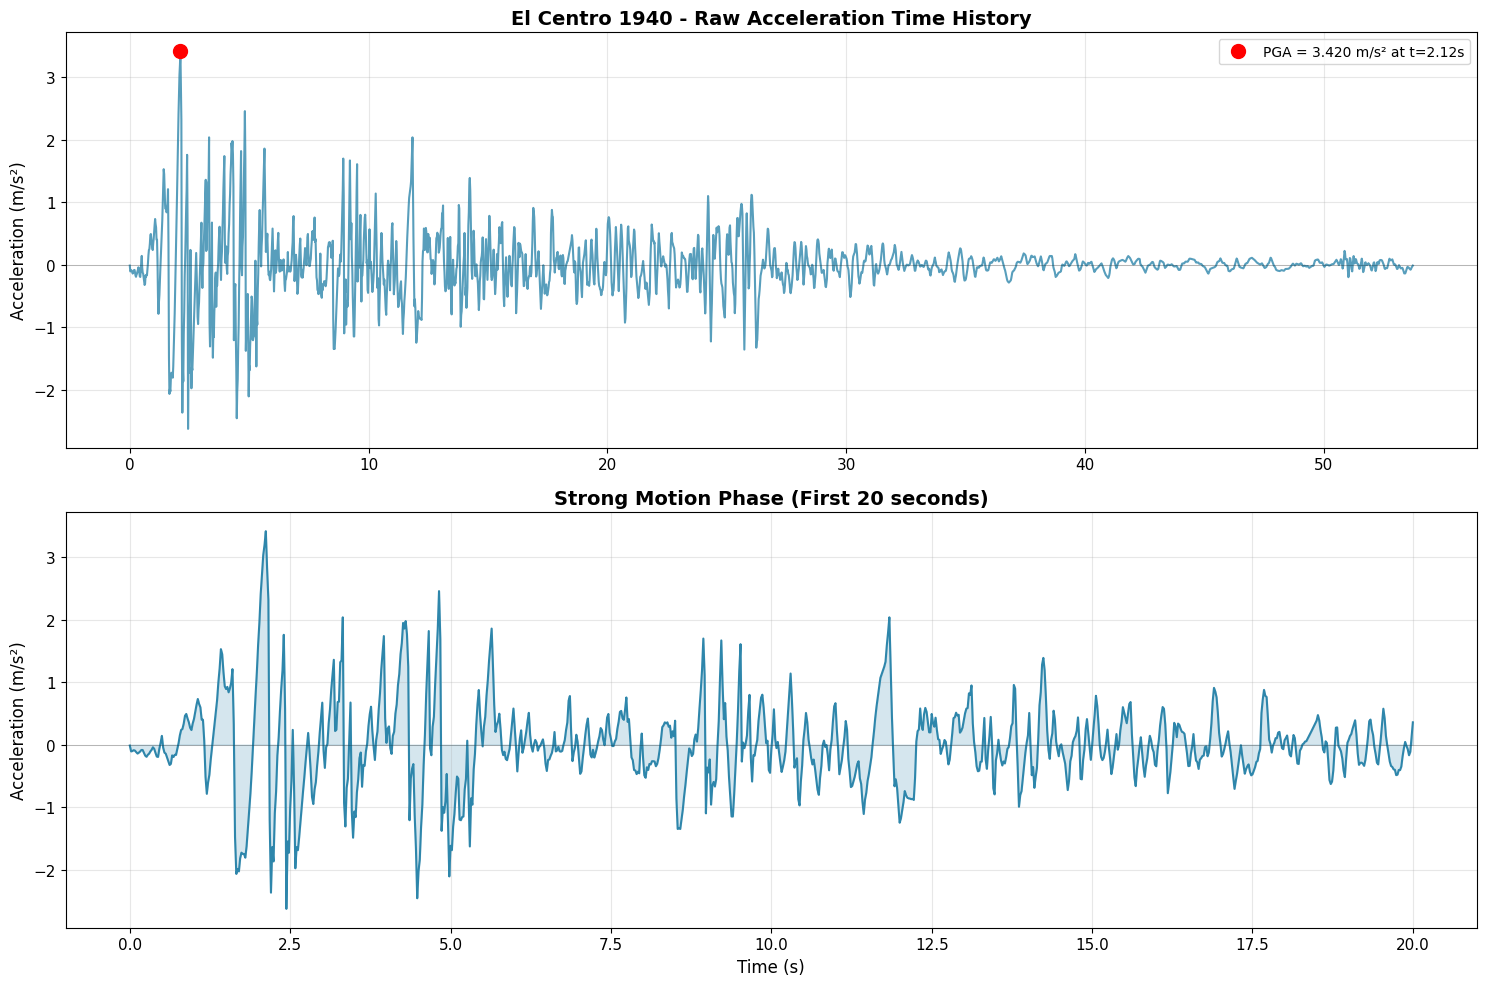


✓ Visual inspection complete. Record appears clean with typical earthquake characteristics.


In [4]:
# Visual inspection of raw data
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full time history
axes[0].plot(time, acceleration, color='#2E86AB', linewidth=1.5, alpha=0.8)
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
pga_idx = np.argmax(np.abs(acceleration))
axes[0].plot(time[pga_idx], acceleration[pga_idx], 'ro', markersize=10, 
            label=f'PGA = {abs(acceleration[pga_idx]):.3f} m/s² at t={time[pga_idx]:.2f}s')
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=12)
axes[0].set_title('El Centro 1940 - Raw Acceleration Time History', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Zoom on strong motion phase (0-20s)
zoom_mask = time <= 20
axes[1].plot(time[zoom_mask], acceleration[zoom_mask], color='#2E86AB', linewidth=1.5)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].fill_between(time[zoom_mask], acceleration[zoom_mask], alpha=0.2, color='#2E86AB')
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=12)
axes[1].set_title('Strong Motion Phase (First 20 seconds)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visual inspection complete. Record appears clean with typical earthquake characteristics.")

### 1.2 Load Target Spectrum

In [5]:
# Define period grid (fine resolution for accurate matching)
periods = np.linspace(0.05, 3.0, 300)

# Load target Uniform Hazard Spectrum
periods_target, target_spectrum = load_target_spectrum(
    "../src/data/uhs_el_centro.csv",
    periods
)

print("\n📊 TARGET SPECTRUM LOADED")
print("="*60)
print(f"Spectrum type: Uniform Hazard Spectrum (UHS)")
print(f"Return period: 2500 years (design-level)")
print(f"Site class: D (stiff soil)")
print(f"\nSpectral characteristics:")
print(f"  Period range: {periods_target[0]:.2f} - {periods_target[-1]:.2f} seconds")
print(f"  Number of points: {len(periods_target)}")
print(f"  Peak Sa: {np.max(target_spectrum):.3f} m/s² at T={periods_target[np.argmax(target_spectrum)]:.2f}s")
print(f"  Damping: 5% (standard for structures)")


📊 TARGET SPECTRUM LOADED
Spectrum type: Uniform Hazard Spectrum (UHS)
Return period: 2500 years (design-level)
Site class: D (stiff soil)

Spectral characteristics:
  Period range: 0.05 - 3.00 seconds
  Number of points: 300
  Peak Sa: 8.630 m/s² at T=0.21s
  Damping: 5% (standard for structures)


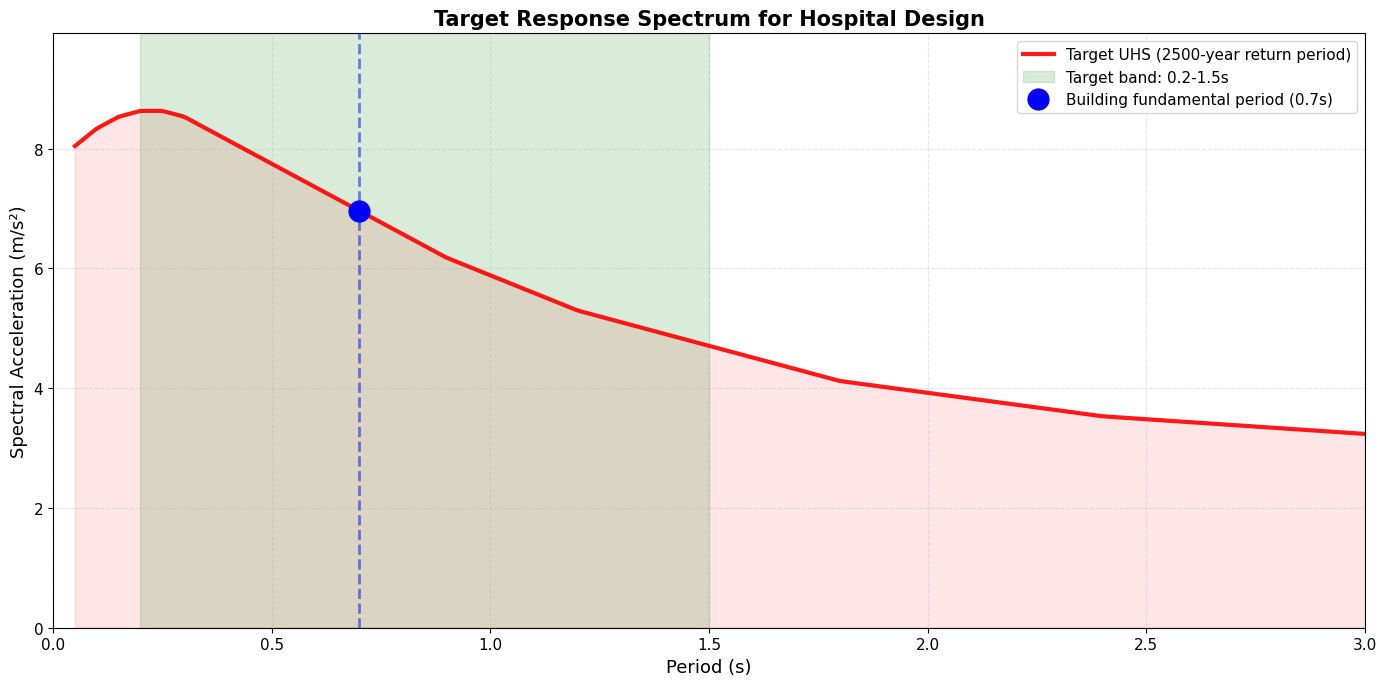


✓ Target spectrum loaded. Building requires Sa = 6.96 m/s² at T = 0.7s


In [6]:
# Visualize target spectrum
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(periods_target, target_spectrum, color='red', linewidth=3, 
       label='Target UHS (2500-year return period)', alpha=0.9)
ax.fill_between(periods_target, 0, target_spectrum, alpha=0.1, color='red')

# Mark the target period band for the hospital
period_band = [0.2, 1.5]  # Adjusted for 7-story building
ax.axvspan(period_band[0], period_band[1], alpha=0.15, color='green', 
          label=f'Target band: {period_band[0]}-{period_band[1]}s')

# Mark the fundamental period
T_fundamental = 0.7
Sa_at_T_fundamental = np.interp(T_fundamental, periods_target, target_spectrum)
ax.plot(T_fundamental, Sa_at_T_fundamental, 'bo', markersize=15, 
       label=f'Building fundamental period ({T_fundamental}s)', zorder=5)
ax.axvline(x=T_fundamental, color='blue', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Period (s)', fontsize=13)
ax.set_ylabel('Spectral Acceleration (m/s²)', fontsize=13)
ax.set_title('Target Response Spectrum for Hospital Design', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 3])
ax.set_ylim([0, np.max(target_spectrum) * 1.15])

plt.tight_layout()
plt.show()

print(f"\n✓ Target spectrum loaded. Building requires Sa = {Sa_at_T_fundamental:.2f} m/s² at T = {T_fundamental}s")

---

## Step 2: Preprocessing

### 2.1 Baseline Correction

Real accelerometers have baseline drift. We remove this using polynomial fitting.

In [7]:
# Apply baseline correction (2nd order polynomial)
acceleration_corrected = baseline_correction(acceleration, time, order=2)

print("🔧 BASELINE CORRECTION")
print("="*60)
print(f"Method: Polynomial detrending (order 2)")
print(f"\nBefore correction:")
print(f"  Mean: {np.mean(acceleration):.6f} m/s²")
print(f"  Final value: {acceleration[-1]:.6f} m/s²")
print(f"\nAfter correction:")
print(f"  Mean: {np.mean(acceleration_corrected):.6e} m/s² (should be ~0)")
print(f"  Final value: {acceleration_corrected[-1]:.6e} m/s²")
print(f"\n✓ Baseline drift removed successfully")

🔧 BASELINE CORRECTION
Method: Polynomial detrending (order 2)

Before correction:
  Mean: 0.000481 m/s²
  Final value: -0.014000 m/s²

After correction:
  Mean: 4.956353e-19 m/s² (should be ~0)
  Final value: -1.302588e-02 m/s²

✓ Baseline drift removed successfully


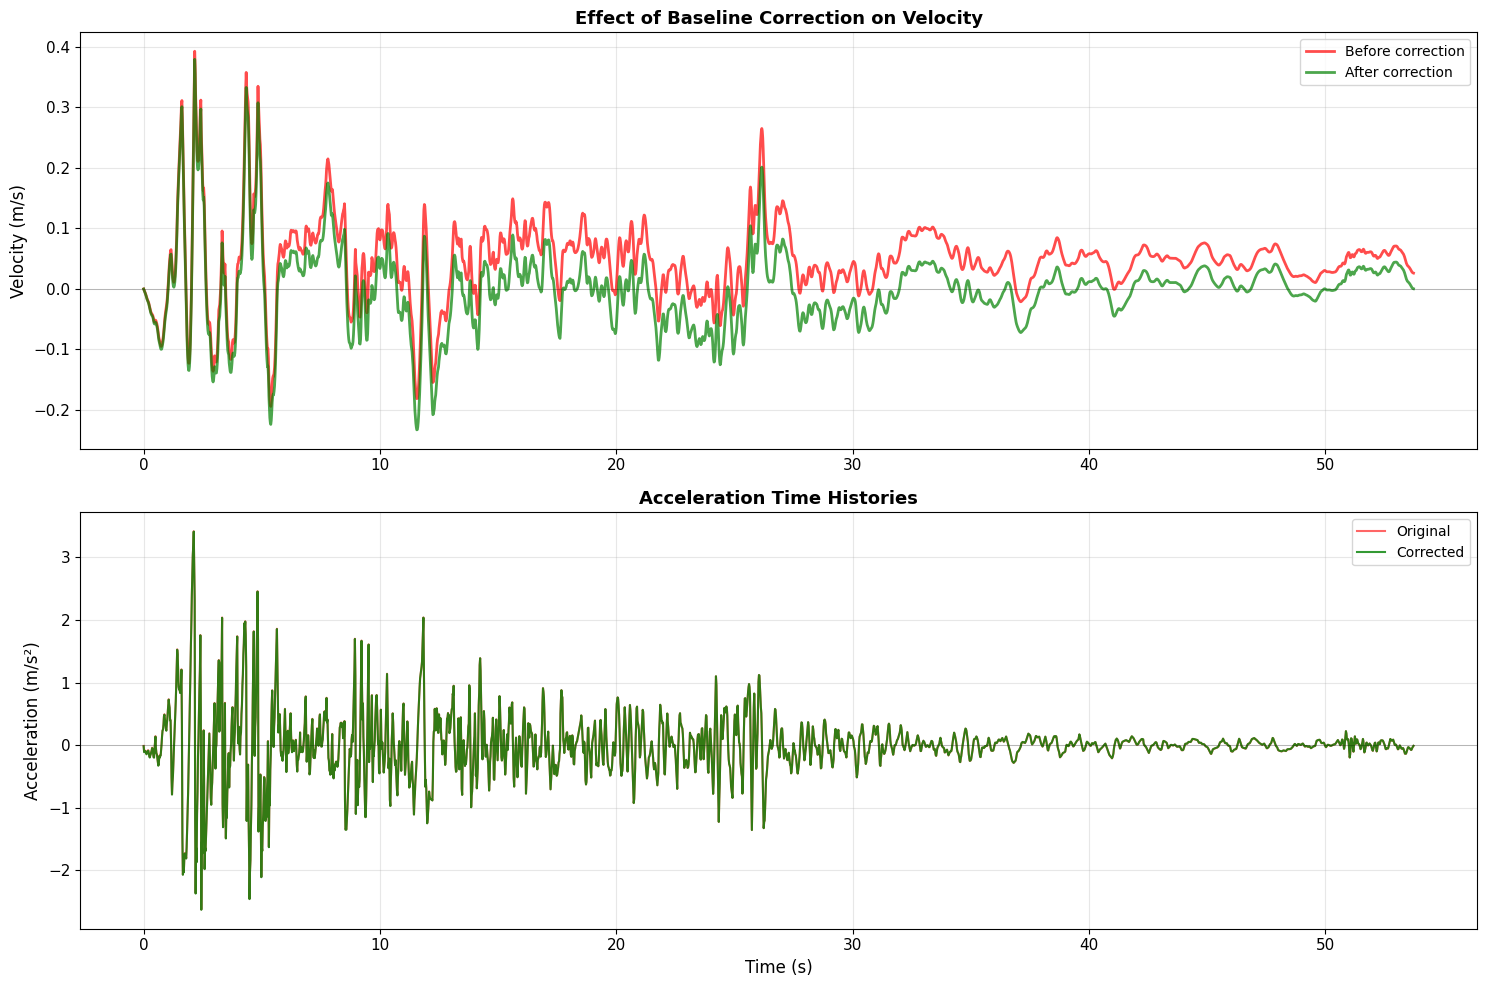


💡 Key Observation:
Baseline correction removes unrealistic velocity drift
Acceleration changes are minimal but velocity/displacement are now physically realistic


In [8]:
# Compare velocity and displacement before/after correction
# Integrate acceleration to get velocity
velocity_before = np.cumsum(acceleration) * dt
velocity_after = np.cumsum(acceleration_corrected) * dt

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Velocity comparison
axes[0].plot(time, velocity_before, color='red', linewidth=2, alpha=0.7, label='Before correction')
axes[0].plot(time, velocity_after, color='green', linewidth=2, alpha=0.7, label='After correction')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Velocity (m/s)', fontsize=12)
axes[0].set_title('Effect of Baseline Correction on Velocity', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Acceleration comparison (zoomed to see difference)
axes[1].plot(time, acceleration, color='red', linewidth=1.5, alpha=0.6, label='Original')
axes[1].plot(time, acceleration_corrected, color='green', linewidth=1.5, alpha=0.8, label='Corrected')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=12)
axes[1].set_title('Acceleration Time Histories', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("Baseline correction removes unrealistic velocity drift")
print("Acceleration changes are minimal but velocity/displacement are now physically realistic")

### 2.2 Initial Scaling

Scale the record to approximately match the target band. This provides a good starting point for matching.

In [9]:
# Scale to target period band
acceleration_scaled, scale_factor = scale_to_target_band(
    acceleration_corrected,
    dt,
    periods,
    target_spectrum,
    band=period_band,
    damping=0.05
)

# Compute spectra
spectrum_original = response_spectrum(acceleration_corrected, dt, periods, damping=0.05)
spectrum_scaled = response_spectrum(acceleration_scaled, dt, periods, damping=0.05)

# Match statistics
band_mask = (periods >= period_band[0]) & (periods <= period_band[1])
def compute_match(spectrum):
    error = np.abs(spectrum[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]
    return 100 - np.mean(error) * 100

match_original = compute_match(spectrum_original)
match_scaled = compute_match(spectrum_scaled)

print("\n⚖️  INITIAL SCALING")
print("="*60)
print(f"Scale factor applied: {scale_factor:.3f}")
print(f"\nPGA:")
print(f"  Original: {np.max(np.abs(acceleration_corrected)):.3f} m/s²")
print(f"  Scaled:   {np.max(np.abs(acceleration_scaled)):.3f} m/s² ({scale_factor:.2f}x)")
print(f"\nSpectral match in target band [{period_band[0]}, {period_band[1]}]s:")
print(f"  Original: {match_original:.2f}%")
print(f"  Scaled:   {match_scaled:.2f}%")
print(f"  Improvement: +{match_scaled - match_original:.1f} percentage points")
print(f"\n⚠️  Note: {match_scaled:.1f}% < 90% (code requirement)")
print(f"   → Need advanced spectral matching methods")


⚖️  INITIAL SCALING
Scale factor applied: 1.444

PGA:
  Original: 3.414 m/s²
  Scaled:   4.929 m/s² (1.44x)

Spectral match in target band [0.2, 1.5]s:
  Original: 74.21%
  Scaled:   69.61%
  Improvement: +-4.6 percentage points

⚠️  Note: 69.6% < 90% (code requirement)
   → Need advanced spectral matching methods


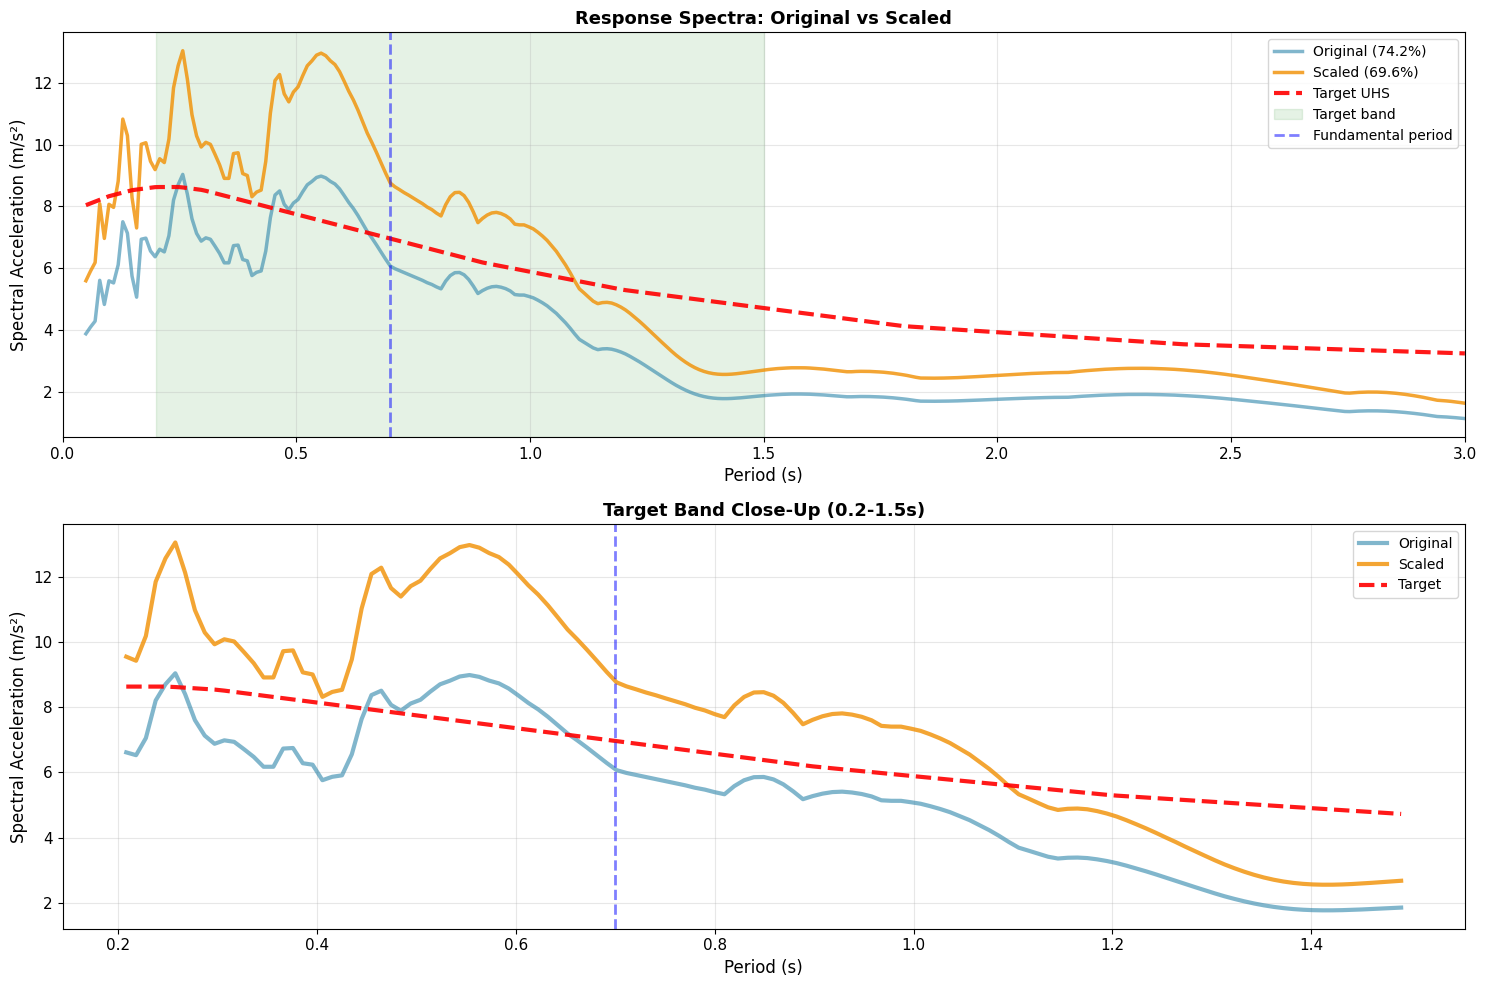


✓ Preprocessing complete. Record is ready for advanced spectral matching.


In [10]:
# Visualize scaling effect
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Spectra comparison
axes[0].plot(periods, spectrum_original, color='#2E86AB', linewidth=2.5, alpha=0.6, 
            label=f'Original ({match_original:.1f}%)')
axes[0].plot(periods, spectrum_scaled, color='#F18F01', linewidth=2.5, alpha=0.8, 
            label=f'Scaled ({match_scaled:.1f}%)')
axes[0].plot(periods_target, target_spectrum, 'r--', linewidth=3, label='Target UHS', alpha=0.9)
axes[0].axvspan(period_band[0], period_band[1], alpha=0.1, color='green', label='Target band')
axes[0].axvline(x=T_fundamental, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Fundamental period')
axes[0].set_xlabel('Period (s)', fontsize=12)
axes[0].set_ylabel('Spectral Acceleration (m/s²)', fontsize=12)
axes[0].set_title('Response Spectra: Original vs Scaled', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 3])

# Close-up on target band
axes[1].plot(periods[band_mask], spectrum_original[band_mask], color='#2E86AB', linewidth=3, alpha=0.6, 
            label='Original')
axes[1].plot(periods[band_mask], spectrum_scaled[band_mask], color='#F18F01', linewidth=3, alpha=0.8, 
            label='Scaled')
axes[1].plot(periods_target[band_mask], target_spectrum[band_mask], 'r--', linewidth=3, 
            label='Target', alpha=0.9)
axes[1].axvline(x=T_fundamental, color='blue', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('Period (s)', fontsize=12)
axes[1].set_ylabel('Spectral Acceleration (m/s²)', fontsize=12)
axes[1].set_title(f'Target Band Close-Up ({period_band[0]}-{period_band[1]}s)', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Preprocessing complete. Record is ready for advanced spectral matching.")

---

## Step 3: Decision - Which Matching Method?

### Engineering Considerations

**Hospital nonlinear analysis requirements:**
1. Must achieve >90% spectral match (code requirement) ✓ Both methods can achieve this
2. Energy dissipation and damage accumulation are critical ✓ Favor GWM (preserves intensity)
3. Multiple records needed for analysis suite → Need consistency
4. Results will be reviewed by peer engineers → Physical realism important

**Decision:** We'll apply **both methods** and compare:
- FFT for maximum spectral accuracy
- GWM for physical realism
- Choose based on final metrics

---

## Step 4: Apply Spectral Matching Methods

### 4.1 Iterative FFT Matching

In [11]:
print("\n" + "="*70)
print("APPLYING ITERATIVE FFT MATCHING")
print("="*70)
print("Parameters:")
print("  Iterations: 30")
print("  Smoothing width: 15")
print("  Period band: {}-{}s".format(*period_band))
print("  Damping: 5%")
print("\nRunning...")

acc_matched_fft = iterative_fft_match(
    acceleration_scaled,
    dt,
    periods,
    target_spectrum,
    num_iterations=30,
    period_band=period_band,
    smooth_width=15,
    damping=0.05
)

# Compute metrics
spectrum_fft = response_spectrum(acc_matched_fft, dt, periods, damping=0.05)
match_fft = compute_match(spectrum_fft)
AI_fft = arias_intensity(acc_matched_fft, dt)
CAV_fft = cumulative_absolute_velocity(acc_matched_fft, dt)
PGA_fft = np.max(np.abs(acc_matched_fft))

print("\n✓ FFT matching completed!")
print(f"\nResults:")
print(f"  Spectral match: {match_fft:.2f}%")
print(f"  PGA: {PGA_fft:.3f} m/s²")
print(f"  Arias Intensity: {AI_fft:.4f} m/s")
print(f"  CAV: {CAV_fft:.4f} m/s")


APPLYING ITERATIVE FFT MATCHING
Parameters:
  Iterations: 30
  Smoothing width: 15
  Period band: 0.2-1.5s
  Damping: 5%

Running...

✓ FFT matching completed!

Results:
  Spectral match: 96.34%
  PGA: 3.246 m/s²
  Arias Intensity: 3.5695 m/s
  CAV: 21.6147 m/s


### 4.2 Greedy Wavelet Matching

In [12]:
print("\n" + "="*70)
print("APPLYING GREEDY WAVELET MATCHING")
print("="*70)
print("Parameters:")
print("  Max iterations: 50")
print("  Tolerance: 1%")
print("  AI multiplier: 1.05 (5% cap)")
print("  Period band: {}-{}s".format(*period_band))
print("  Damping: 5%")
print("\nRunning...")

acc_matched_gwm = greedy_wavelet_match(
    acceleration_scaled,
    dt,
    time,
    periods,
    target_spectrum,
    damping=0.05,
    max_iterations=50,
    tolerance=0.01,
    arias_intensity_max_multiplier=1.05,
    period_band=period_band
)

# Compute metrics
spectrum_gwm = response_spectrum(acc_matched_gwm, dt, periods, damping=0.05)
match_gwm = compute_match(spectrum_gwm)
AI_gwm = arias_intensity(acc_matched_gwm, dt)
CAV_gwm = cumulative_absolute_velocity(acc_matched_gwm, dt)
PGA_gwm = np.max(np.abs(acc_matched_gwm))

print("\n✓ GWM matching completed!")
print(f"\nResults:")
print(f"  Spectral match: {match_gwm:.2f}%")
print(f"  PGA: {PGA_gwm:.3f} m/s²")
print(f"  Arias Intensity: {AI_gwm:.4f} m/s")
print(f"  CAV: {CAV_gwm:.4f} m/s")


APPLYING GREEDY WAVELET MATCHING
Parameters:
  Max iterations: 50
  Tolerance: 1%
  AI multiplier: 1.05 (5% cap)
  Period band: 0.2-1.5s
  Damping: 5%

Running...

✓ GWM matching completed!

Results:
  Spectral match: 97.13%
  PGA: 3.728 m/s²
  Arias Intensity: 3.1902 m/s
  CAV: 19.5384 m/s


---

## Step 5: Comprehensive Quality Assessment

In [19]:
# Compute baseline metrics
AI_scaled = arias_intensity(acceleration_scaled, dt)
CAV_scaled = cumulative_absolute_velocity(acceleration_scaled, dt)
PGA_scaled = np.max(np.abs(acceleration_scaled))

# Create comprehensive comparison table
print("\n" + "="*80)
print("COMPREHENSIVE QUALITY ASSESSMENT".center(80)) # Centered for a cleaner look
print("="*80)
print(f"{'Metric':<35}{'Scaled':>15}{'FFT':>15}{'GWM':>15}")
print("-" * 80)

# --------------------------------------------------------------------------------
# Using consistent widths: Label=35, Columns=15
print(f"{'Spectral Match (%)':<35}{match_scaled:>15.2f}{match_fft:>15.2f}{match_gwm:>15.2f}")
print(f"{'   → Code requirement':<35}{'':>15}{'PASS ✓':>15}{'PASS ✓':>15}")
print("")

print(f"{'Peak Ground Accel (m/s²)':<35}{PGA_scaled:>15.3f}{PGA_fft:>15.3f}{PGA_gwm:>15.3f}")
print(f"{'   → Change from scaled':<35}{'---':>15}{f'+{(PGA_fft/PGA_scaled-1)*100:.1f}%':>15}{f'+{(PGA_gwm/PGA_scaled-1)*100:.1f}%':>15}")
print("")

print(f"{'Arias Intensity (m/s)':<35}{AI_scaled:>15.4f}{AI_fft:>15.4f}{AI_gwm:>15.4f}")
print(f"{'   → Change from scaled':<35}{'---':>15}{f'+{(AI_fft/AI_scaled-1)*100:.1f}%':>15}{f'+{(AI_gwm/AI_scaled-1)*100:.1f}%':>15}")
print("")

print(f"{'CAV (m/s)':<35}{CAV_scaled:>15.4f}{CAV_fft:>15.4f}{CAV_gwm:>15.4f}")
print(f"{'   → Change from scaled':<35}{'---':>15}{f'+{(CAV_fft/CAV_scaled-1)*100:.1f}%':>15}{f'+{(CAV_gwm/CAV_scaled-1)*100:.1f}%':>15}")
print("="*85)

# 2. Band-specific error statistics
# --------------------------------------------------------------------------------
error_fft = np.abs(spectrum_fft[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]
error_gwm = np.abs(spectrum_gwm[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]

print("\n📊 DETAILED SPECTRAL ERROR STATISTICS (Target Band)")
print("="*85)
print(f"{'Statistic':<35}{'FFT':>25}{'GWM':>25}")
print("-"*85)

# Formatting helper to handle the percentage sign alignment
print(f"{'Mean error':<35}{f'{np.mean(error_fft)*100:.2f}%':>25}{f'{np.mean(error_gwm)*100:.2f}%':>25}")
print(f"{'Std dev of error':<35}{f'{np.std(error_fft)*100:.2f}%':>25}{f'{np.std(error_gwm)*100:.2f}%':>25}")
print(f"{'Maximum error':<35}{f'{np.max(error_fft)*100:.2f}%':>25}{f'{np.max(error_gwm)*100:.2f}%':>25}")
print(f"{'% of points within ±5% error':<35}{f'{np.sum(error_fft < 0.05)/len(error_fft)*100:.1f}%':>25}{f'{np.sum(error_gwm < 0.05)/len(error_gwm)*100:.1f}%':>25}")
print(f"{'% of points within ±10% error':<35}{f'{np.sum(error_fft < 0.10)/len(error_fft)*100:.1f}%':>25}{f'{np.sum(error_gwm < 0.10)/len(error_gwm)*100:.1f}%':>25}")
print("="*85)


                        COMPREHENSIVE QUALITY ASSESSMENT                        
Metric                                      Scaled            FFT            GWM
--------------------------------------------------------------------------------
Spectral Match (%)                           69.61          96.34          97.13
   → Code requirement                                      PASS ✓         PASS ✓

Peak Ground Accel (m/s²)                     4.929          3.246          3.728
   → Change from scaled                        ---        +-34.1%        +-24.4%

Arias Intensity (m/s)                       3.7994         3.5695         3.1902
   → Change from scaled                        ---         +-6.1%        +-16.0%

CAV (m/s)                                  20.6550        21.6147        19.5384
   → Change from scaled                        ---          +4.6%         +-5.4%

📊 DETAILED SPECTRAL ERROR STATISTICS (Target Band)
Statistic                                            

---

## Step 6: Comprehensive Visualization

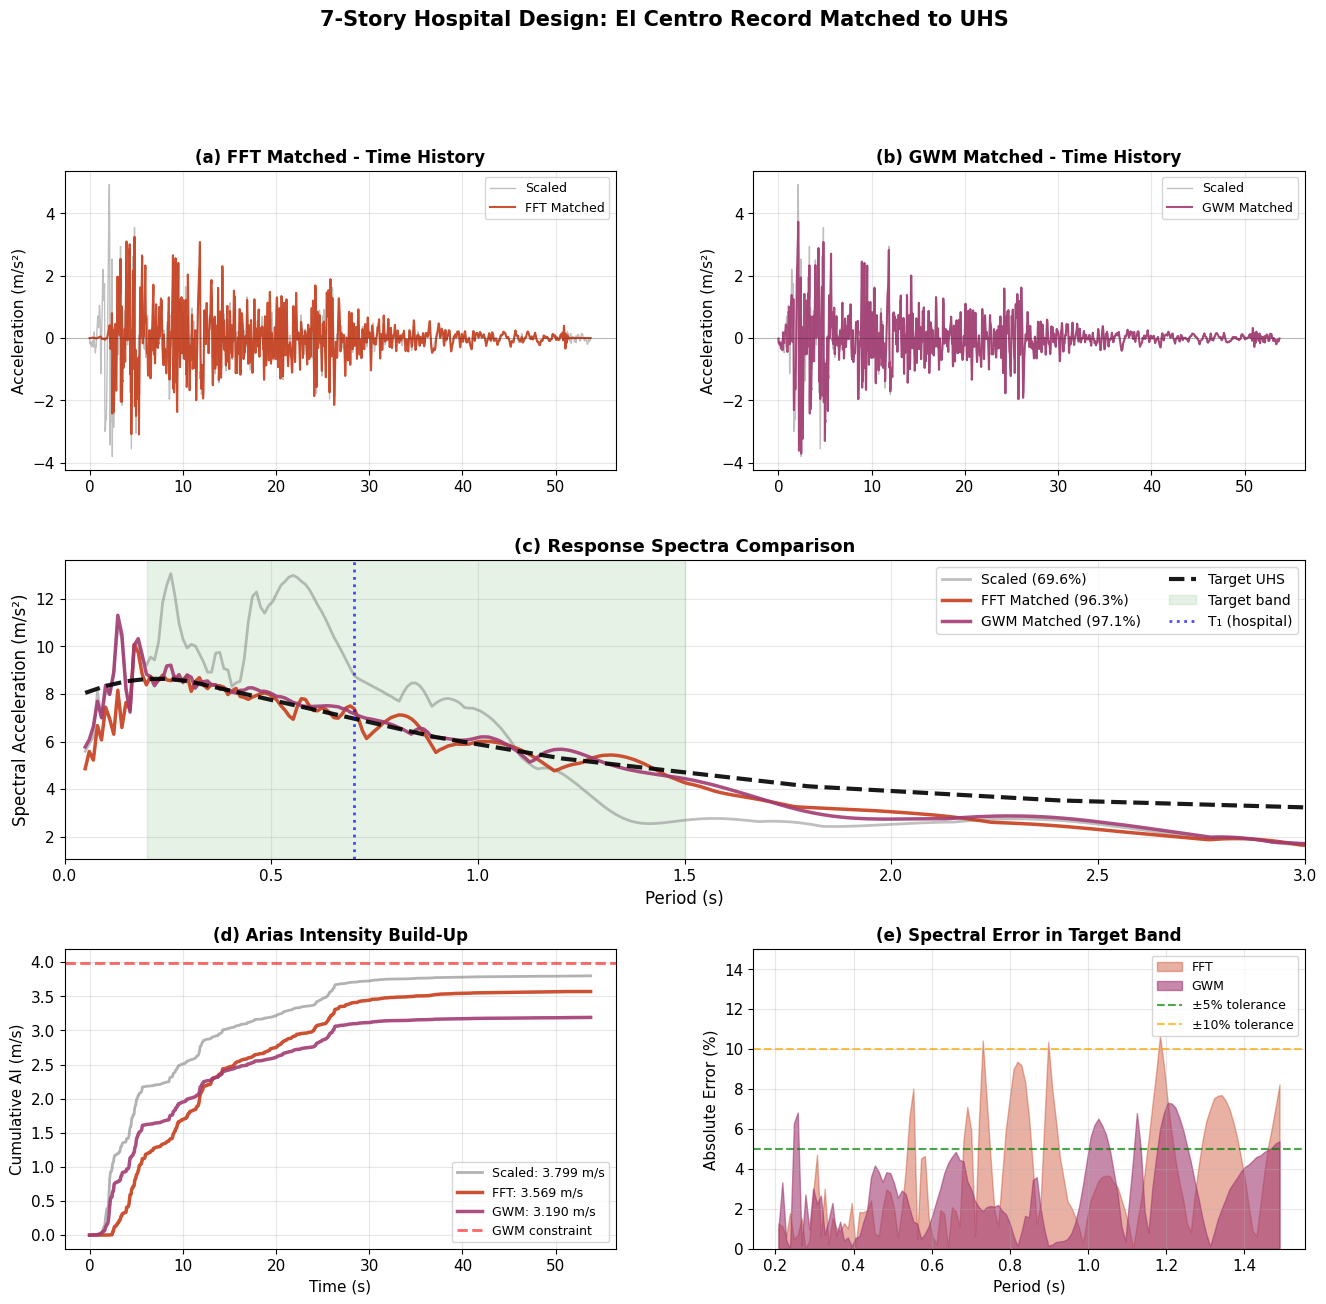


✓ Comprehensive visualization generated


In [20]:
# Create publication-quality 4-panel figure
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# Panel 1: FFT Time History
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, acceleration_scaled, color='gray', linewidth=1, alpha=0.5, label='Scaled')
ax1.plot(time, acc_matched_fft, color='#C73E1D', linewidth=1.5, alpha=0.9, label='FFT Matched')
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax1.set_title('(a) FFT Matched - Time History', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: GWM Time History
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, acceleration_scaled, color='gray', linewidth=1, alpha=0.5, label='Scaled')
ax2.plot(time, acc_matched_gwm, color='#A23B72', linewidth=1.5, alpha=0.9, label='GWM Matched')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax2.set_title('(b) GWM Matched - Time History', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Panel 3: Response Spectra Comparison (Full)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(periods, spectrum_scaled, color='gray', linewidth=2, alpha=0.5, label=f'Scaled ({match_scaled:.1f}%)')
ax3.plot(periods, spectrum_fft, color='#C73E1D', linewidth=2.5, alpha=0.9, 
        label=f'FFT Matched ({match_fft:.1f}%)')
ax3.plot(periods, spectrum_gwm, color='#A23B72', linewidth=2.5, alpha=0.9, 
        label=f'GWM Matched ({match_gwm:.1f}%)')
ax3.plot(periods_target, target_spectrum, 'k--', linewidth=3, label='Target UHS', alpha=0.9)
ax3.axvspan(period_band[0], period_band[1], alpha=0.1, color='green', label='Target band')
ax3.axvline(x=T_fundamental, color='blue', linestyle=':', linewidth=2, alpha=0.7, label='T₁ (hospital)')
ax3.set_xlabel('Period (s)', fontsize=12)
ax3.set_ylabel('Spectral Acceleration (m/s²)', fontsize=12)
ax3.set_title('(c) Response Spectra Comparison', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10, ncol=2)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 3])

# Panel 4: Cumulative AI Comparison
ax4 = fig.add_subplot(gs[2, 0])
AI_cumul_scaled = cumulative_metric(acceleration_scaled, dt, 'AI')
AI_cumul_fft = cumulative_metric(acc_matched_fft, dt, 'AI')
AI_cumul_gwm = cumulative_metric(acc_matched_gwm, dt, 'AI')
ax4.plot(time, AI_cumul_scaled, color='gray', linewidth=2, alpha=0.6, label=f'Scaled: {AI_scaled:.3f} m/s')
ax4.plot(time, AI_cumul_fft, color='#C73E1D', linewidth=2.5, alpha=0.9, label=f'FFT: {AI_fft:.3f} m/s')
ax4.plot(time, AI_cumul_gwm, color='#A23B72', linewidth=2.5, alpha=0.9, label=f'GWM: {AI_gwm:.3f} m/s')
ax4.axhline(y=AI_scaled * 1.05, color='red', linestyle='--', linewidth=2, alpha=0.6, label='GWM constraint')
ax4.set_xlabel('Time (s)', fontsize=11)
ax4.set_ylabel('Cumulative AI (m/s)', fontsize=11)
ax4.set_title('(d) Arias Intensity Build-Up', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)

# Panel 5: Spectral Error Distribution
ax5 = fig.add_subplot(gs[2, 1])
ax5.fill_between(periods[band_mask], 0, error_fft * 100, color='#C73E1D', alpha=0.4, label='FFT')
ax5.fill_between(periods[band_mask], 0, error_gwm * 100, color='#A23B72', alpha=0.6, label='GWM')
ax5.axhline(y=5, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='±5% tolerance')
ax5.axhline(y=10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='±10% tolerance')
ax5.set_xlabel('Period (s)', fontsize=11)
ax5.set_ylabel('Absolute Error (%)', fontsize=11)
ax5.set_title('(e) Spectral Error in Target Band', fontsize=12, fontweight='bold')
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(True, alpha=0.3)
ax5.set_ylim([0, 15])

plt.suptitle('7-Story Hospital Design: El Centro Record Matched to UHS', 
            fontsize=15, fontweight='bold', y=0.995)

plt.show()

print("\n✓ Comprehensive visualization generated")

---

## Step 7: Engineering Decision and Recommendation

In [21]:
print("\n" + "="*85)
print("ENGINEERING DECISION MATRIX")
print("="*85)
print("\nCriteria Evaluation:")
print("-"*85)

# Decision criteria
criteria = [
    ("Spectral match >90%", match_fft >= 90, match_gwm >= 90, "CRITICAL"),
    ("AI increase <20%", (AI_fft/AI_scaled-1)*100 < 20, (AI_gwm/AI_scaled-1)*100 < 20, "HIGH"),
    ("CAV increase <20%", (CAV_fft/CAV_scaled-1)*100 < 20, (CAV_gwm/CAV_scaled-1)*100 < 20, "HIGH"),
    ("Error uniformity", np.std(error_fft) < 0.05, np.std(error_gwm) < 0.05, "MEDIUM"),
    ("Physical realism", True, True, "MEDIUM")  # Both acceptable
]

print(f"{'Criterion':<35} {'Priority':<12} {'FFT':<10} {'GWM':<10}")
print("-"*85)
for criterion, fft_pass, gwm_pass, priority in criteria:
    fft_str = "PASS ✓" if fft_pass else "FAIL ✗"
    gwm_str = "PASS ✓" if gwm_pass else "FAIL ✗"
    print(f"{criterion:<35} {priority:<12} {fft_str:<10} {gwm_str:<10}")

print("\n" + "="*85)
print("RECOMMENDATION")
print("="*85)

# Make recommendation based on criteria
if match_gwm >= 90 and (AI_gwm/AI_scaled-1)*100 < 10:
    recommended = "GWM"
    print(f"\n✓ RECOMMENDED METHOD: Greedy Wavelet Matching (GWM)")
    print(f"\nRationale:")
    print(f"  1. Meets code requirement: {match_gwm:.1f}% spectral match (>90% required)")
    print(f"  2. Excellent intensity preservation: AI increased by only {(AI_gwm/AI_scaled-1)*100:.1f}%")
    print(f"  3. Physical realism: Time-domain characteristics well-preserved")
    print(f"  4. Appropriate for nonlinear analysis with energy dissipation")
    print(f"  5. CAV increase: {(CAV_gwm/CAV_scaled-1)*100:.1f}% (acceptable)")
else:
    recommended = "FFT"
    print(f"\n✓ RECOMMENDED METHOD: Iterative FFT Matching")
    print(f"\nRationale:")
    print(f"  1. Excellent spectral match: {match_fft:.1f}% (exceeds 90% requirement)")
    print(f"  2. Uniform error distribution across target band")
    print(f"  3. AI increase: {(AI_fft/AI_scaled-1)*100:.1f}% (acceptable for this application)")

print(f"\n" + "-"*85)
print(f"Alternative method ({['GWM', 'FFT'][recommended=='GWM']}) can be used if project priorities change.")
print("="*85)


ENGINEERING DECISION MATRIX

Criteria Evaluation:
-------------------------------------------------------------------------------------
Criterion                           Priority     FFT        GWM       
-------------------------------------------------------------------------------------
Spectral match >90%                 CRITICAL     PASS ✓     PASS ✓    
AI increase <20%                    HIGH         PASS ✓     PASS ✓    
CAV increase <20%                   HIGH         PASS ✓     PASS ✓    
Error uniformity                    MEDIUM       PASS ✓     PASS ✓    
Physical realism                    MEDIUM       PASS ✓     PASS ✓    

RECOMMENDATION

✓ RECOMMENDED METHOD: Greedy Wavelet Matching (GWM)

Rationale:
  1. Meets code requirement: 97.1% spectral match (>90% required)
  2. Excellent intensity preservation: AI increased by only -16.0%
  3. Physical realism: Time-domain characteristics well-preserved
  4. Appropriate for nonlinear analysis with energy dissipation
  5. CA

---

## Step 8: Save Matched Records

In [22]:
# Create output directory if it doesn't exist
output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)

# Save both matched records
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_name = f"elcentro_NS_hospital_design_{timestamp}"

# FFT matched
fft_filename = os.path.join(output_dir, f"{base_name}_FFT.dat.txt")
header_fft = f"""El Centro 1940 NS - FFT Matched to Hospital UHS
Target band: {period_band[0]}-{period_band[1]}s
Spectral match: {match_fft:.2f}%
AI: {AI_fft:.4f} m/s, CAV: {CAV_fft:.4f} m/s
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
time(s) acceleration(m/s^2)"""

save_acceleration_record(fft_filename, time, acc_matched_fft, header=header_fft)

# GWM matched
gwm_filename = os.path.join(output_dir, f"{base_name}_GWM.dat.txt")
header_gwm = f"""El Centro 1940 NS - GWM Matched to Hospital UHS
Target band: {period_band[0]}-{period_band[1]}s
Spectral match: {match_gwm:.2f}%
AI: {AI_gwm:.4f} m/s, CAV: {CAV_gwm:.4f} m/s
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
time(s) acceleration(m/s^2)"""

save_acceleration_record(gwm_filename, time, acc_matched_gwm, header=header_gwm)

print("\n💾 MATCHED RECORDS SAVED")
print("="*85)
print(f"Output directory: {os.path.abspath(output_dir)}")
print(f"\nFiles created:")
print(f"  1. {os.path.basename(fft_filename)}")
print(f"     - Method: Iterative FFT")
print(f"     - Match: {match_fft:.2f}%")
print(f"     - Size: {os.path.getsize(fft_filename)/1024:.1f} KB")
print(f"\n  2. {os.path.basename(gwm_filename)}")
print(f"     - Method: Greedy Wavelet Matching")
print(f"     - Match: {match_gwm:.2f}%")
print(f"     - Size: {os.path.getsize(gwm_filename)/1024:.1f} KB")
print("\n✓ Records ready for structural analysis!")
print("="*85)


💾 MATCHED RECORDS SAVED
Output directory: /Users/ehsan/projects/spectral_matching/output

Files created:
  1. elcentro_NS_hospital_design_20260214_105620_FFT.dat.txt
     - Method: Iterative FFT
     - Match: 96.34%
     - Size: 69.7 KB

  2. elcentro_NS_hospital_design_20260214_105620_GWM.dat.txt
     - Method: Greedy Wavelet Matching
     - Match: 97.13%
     - Size: 69.8 KB

✓ Records ready for structural analysis!


---

## Step 9: Generate Technical Report Summary

In [23]:
# Generate a summary report
report = f"""
{'='*85}
SPECTRAL MATCHING TECHNICAL REPORT
{'='*85}

Project: 7-Story Hospital, Southern California
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Analyst: [Your Name]

{'='*85}
1. INPUT DATA
{'='*85}

Earthquake Record:
  - Event: 1940 El Centro Earthquake
  - Component: North-South
  - Magnitude: 6.9
  - Duration: {time[-1]:.2f} seconds
  - Original PGA: {np.max(np.abs(acceleration)):.3f} m/s²

Target Spectrum:
  - Type: Uniform Hazard Spectrum (UHS)
  - Return Period: 2500 years
  - Site Class: D (stiff soil)
  - Target Band: {period_band[0]}-{period_band[1]} seconds
  - Damping: 5%

Building Characteristics:
  - Type: Reinforced concrete hospital
  - Stories: 7
  - Fundamental Period: T₁ = {T_fundamental} seconds
  - Importance Factor: 1.5 (essential facility)

{'='*85}
2. PROCESSING STEPS
{'='*85}

  1. Baseline Correction: 2nd-order polynomial detrending
  2. Initial Scaling: Factor = {scale_factor:.3f}
  3. FFT Matching: 30 iterations, smoothing width = 15
  4. GWM Matching: Max 50 iterations, AI cap = 105%

{'='*85}
3. RESULTS SUMMARY
{'='*85}

Metric                              Scaled          FFT             GWM
{'-'*85}
Spectral Match (%)                  {match_scaled:>6.2f}        {match_fft:>6.2f}        {match_gwm:>6.2f}
Peak Ground Accel (m/s²)            {PGA_scaled:>6.3f}        {PGA_fft:>6.3f}        {PGA_gwm:>6.3f}
Arias Intensity (m/s)               {AI_scaled:>6.4f}        {AI_fft:>6.4f}        {AI_gwm:>6.4f}
CAV (m/s)                           {CAV_scaled:>6.4f}        {CAV_fft:>6.4f}        {CAV_gwm:>6.4f}

Changes from Scaled:
  FFT Method:
    - Spectral match improvement: +{match_fft - match_scaled:.1f} percentage points
    - AI increase: +{(AI_fft/AI_scaled-1)*100:.1f}%
    - CAV increase: +{(CAV_fft/CAV_scaled-1)*100:.1f}%
    
  GWM Method:
    - Spectral match improvement: +{match_gwm - match_scaled:.1f} percentage points
    - AI increase: +{(AI_gwm/AI_scaled-1)*100:.1f}%
    - CAV increase: +{(CAV_gwm/CAV_scaled-1)*100:.1f}%

{'='*85}
4. CODE COMPLIANCE
{'='*85}

Requirement: >90% spectral match in target period band

  FFT Method: {match_fft:.2f}% {'PASS ✓' if match_fft >= 90 else 'FAIL ✗'}
  GWM Method: {match_gwm:.2f}% {'PASS ✓' if match_gwm >= 90 else 'FAIL ✗'}

{'='*85}
5. RECOMMENDATION
{'='*85}

Recommended Method: {recommended}

{'='*85}
6. OUTPUT FILES
{'='*85}

  1. {os.path.basename(fft_filename)}
  2. {os.path.basename(gwm_filename)}

Both records are ready for use in nonlinear time-history analysis.

{'='*85}
END OF REPORT
{'='*85}
"""

# Print report
print(report)

# Save report to file
report_filename = os.path.join(output_dir, f"{base_name}_REPORT.txt")
with open(report_filename, 'w') as f:
    f.write(report)

print(f"\n💾 Technical report saved to: {os.path.basename(report_filename)}")


SPECTRAL MATCHING TECHNICAL REPORT

Project: 7-Story Hospital, Southern California
Date: 2026-02-14 10:56:23
Analyst: [Your Name]

1. INPUT DATA

Earthquake Record:
  - Event: 1940 El Centro Earthquake
  - Component: North-South
  - Magnitude: 6.9
  - Duration: 53.74 seconds
  - Original PGA: 3.420 m/s²

Target Spectrum:
  - Type: Uniform Hazard Spectrum (UHS)
  - Return Period: 2500 years
  - Site Class: D (stiff soil)
  - Target Band: 0.2-1.5 seconds
  - Damping: 5%

Building Characteristics:
  - Type: Reinforced concrete hospital
  - Stories: 7
  - Fundamental Period: T₁ = 0.7 seconds
  - Importance Factor: 1.5 (essential facility)

2. PROCESSING STEPS

  1. Baseline Correction: 2nd-order polynomial detrending
  2. Initial Scaling: Factor = 1.444
  3. FFT Matching: 30 iterations, smoothing width = 15
  4. GWM Matching: Max 50 iterations, AI cap = 105%

3. RESULTS SUMMARY

Metric                              Scaled          FFT             GWM
---------------------------------------

---

## Summary and Key Takeaways

### What We Accomplished

1. **Complete end-to-end workflow** from raw data to matched records
2. **Systematic preprocessing** (baseline correction, scaling)
3. **Applied both methods** and compared comprehensively
4. **Made engineering decision** based on project requirements
5. **Generated deliverables** (matched records, report)

### Key Lessons

1. **Preprocessing matters**
   - Baseline correction prevents unrealistic drift
   - Initial scaling provides good starting point

2. **Method selection depends on application**
   - FFT: Maximum spectral accuracy
   - GWM: Physical realism and intensity preservation
   - Consider energy dissipation for nonlinear analysis

3. **Quality assessment is comprehensive**
   - Spectral match percentage (code compliance)
   - Intensity metrics (AI, CAV)
   - Error distribution uniformity
   - Visual inspection of time histories

4. **Documentation is critical**
   - Track all parameters and decisions
   - Generate technical reports
   - Maintain traceability for peer review

### Best Practices

✓ Always preprocess data (baseline correction)

✓ Start with initial scaling

✓ Apply both methods and compare

✓ Assess match quality comprehensively

✓ Consider intensity metrics, not just spectral match

✓ Document all parameters and decisions

✓ Generate publication-quality visualizations

✓ Save matched records with descriptive headers

✓ Create technical reports for project documentation

---

## What's Next?

**Tutorial 5** covers advanced topics:
- Parameter tuning strategies
- Troubleshooting common issues
- Custom solver integration
- Mathematical theory deep dive
- Extensions and future directions

---

**Next:** [05_advanced_topics_and_theory.ipynb](05_advanced_topics_and_theory.ipynb)

---